## Model Cp Sensitivity against prediction accuracy 

A high model Cp sensitivity can lead to a lower prediction accuracy as the range of dynamic for the model is expected to be higher 

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Analysis

In [5]:
import pickle 

sensitivity_folder_name = 'cp_model_sensitivity_5node'
combined_folder_name = 'combined_systems_perturbation'
random_seeds = [4,5,6]
feature_random_seed = 50 

# generate experiment id 
exp_ids = []
exp_ids_sensitivity = []
metric_dfs = []
Cp_final_states_all = []
specie_ranges_all = []

for seed in random_seeds:
    experiment_id = combined_folder_name + '_' + str(seed) + '_' + str(feature_random_seed)
    exp_ids.append(experiment_id)
    # load the data
    experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
    metric_df = pd.read_pickle(experiment_folder+'metric_df.pkl')
    metric_dfs.append(metric_df)
    
    exp_id_sens = sensitivity_folder_name + '_' + str(seed) + '_' + str(feature_random_seed)
    exp_ids_sensitivity.append(exp_id_sens)
    # load Cp final states
    experiment_folder_sens = config['DATA_PATH'] + '/' + exp_id_sens + '/'
    Cp_final_states = pd.read_pickle(experiment_folder_sens+'Cp_final_states_sensitivity.pkl')
    Cp_final_states_all.append(Cp_final_states)
    # load specie ranges
    specie_ranges = pd.read_pickle(experiment_folder_sens+'specie_range.pkl')
    specie_ranges_all.append(specie_ranges)

In [26]:
# for each metric df, calculate the mean of the pearson correlation for all rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' and 'Model' is 'Linear Regression'

omics_mean_pearson = []
for metric_df in metric_dfs:
    # filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)'
    filtered_df = metric_df[metric_df['Feature Data'] == 'Mock Omics Data (A+B)']
    # filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
    filtered_df = filtered_df[filtered_df['Model'] == 'Linear Regression']
    # calculate the mean of the pearson correlation for all rows
    omics_mean_pearson.append(filtered_df['Pearson Correlation'].mean())
    
# print to test the result 
print(omics_mean_pearson)

[0.8073877288364704, 0.7120018345594283, 0.8117295085853765]


In [27]:
all_init_species = ['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1', 'B2', 'B3', 'B4']

state_sensitivity_all = []
for i, Cp_final_states in enumerate(Cp_final_states_all):
    # max - min of the Cp final state list 
    state_sensitivity = []  
    for i, specific_states in enumerate(Cp_final_states):
        # get the max and min of the Cp final state list 
        max_state = max(specific_states)
        min_state = min(specific_states)
        # get the range of the Cp final state list 
        range_state = max_state - min_state
        # append to the list 
        state_sensitivity.append(range_state)
    # print the mean of the state sensitivity
    state_sensitivity_all.append(state_sensitivity)
    
# print the mean of the state sensitivity for each experiment
print('State Sensitivity:')
for i, state_sensitivity in enumerate(state_sensitivity_all):
    print(f'Experiment {i+4}: {sum(state_sensitivity)}')

State Sensitivity:
Experiment 4: 45.02297398012708
Experiment 5: 195.1967855331218
Experiment 6: 4.692927240616914


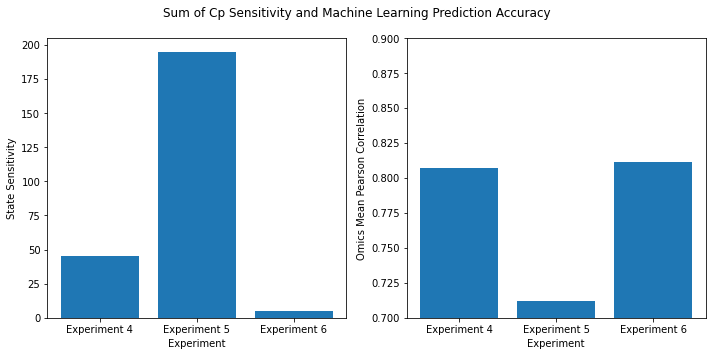

In [29]:
# plot bar chart for state sensitivity and omics mean pearson as a multi plot 

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot the state sensitivity
ax[0].bar(range(len(state_sensitivity_all)), [sum(state_sensitivity) for state_sensitivity in state_sensitivity_all])
ax[0].set_xticks(range(len(state_sensitivity_all)))
ax[0].set_xticklabels([f'Experiment {i+4}' for i in range(len(state_sensitivity_all))])
ax[0].set_ylabel('State Sensitivity')
ax[0].set_xlabel('Experiment')

# plot the omics mean pearson
ax[1].bar(range(len(omics_mean_pearson)), omics_mean_pearson)
ax[1].set_xticks(range(len(omics_mean_pearson)))
ax[1].set_xticklabels([f'Experiment {i+4}' for i in range(len(omics_mean_pearson))])
ax[1].set_ylabel('Omics Mean Pearson Correlation')
ax[1].set_xlabel('Experiment')
# set y limits to be 0.8 to 1 for the omics mean pearson correlation
ax[1].set_ylim(0.7, 0.9)

# set the title for the figure
plt.suptitle('Sum of Cp Sensitivity and Machine Learning Prediction Accuracy')
plt.tight_layout()
plt.show()


In [32]:
example_df = metric_dfs[0]

In [83]:
# perform a multiple t-test for the pearson correlation of the filtered dataframe and adjust the p-values using the Bonferroni correction
from scipy.stats import ttest_rel

def plot_specific_data_types(metric_df, data_types, model):
    # filter the dataframe for the rows where the column 'Feature Data' is in the data_types
    filtered_df = metric_df[metric_df['Feature Data'].isin(data_types)]
    # filter the dataframe for the rows where the column 'Model' is in the model
    filtered_df = filtered_df[filtered_df['Model'] == model]
    plt.figure(figsize=(3, 5))
    sns.set(font_scale=1.8)
    sns.set_style("whitegrid")
    sns.stripplot(data=filtered_df, x='Model', y='Pearson Correlation',
                hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
    sns.boxplot(data=filtered_df, x='Model',
                y='Pearson Correlation', hue='Feature Data')
    for patch in plt.gca().patches:
        patch.set_alpha(0.3)

    plt.title('Model Performance Comparison for Pearson Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    plt.show()
    
    return filtered_df

def get_mean_pearson_pivot(metric_df, data_types, model):
    # filter the dataframe for the rows where the column 'Feature Data' is in the data_types
    filtered_df = metric_df[metric_df['Feature Data'].isin(data_types)]
    # filter the dataframe for the rows where the column 'Model' is in the model
    filtered_df = filtered_df[filtered_df['Model'] == model]
    mean_pearson = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].mean().reset_index()
    # pivot the dataframe to get the mean pearson correlation for each feature data type
    mean_pearson_pivot = mean_pearson.pivot(index='Feature Data', columns='Model', values='Pearson Correlation')
    return mean_pearson_pivot   


def multiple_t_test(metric_df, data_types, model): 
    # apply on the filtered dataframe
    filtered_df = metric_df[metric_df['Model'] == model]
    filtered_df = filtered_df[filtered_df['Feature Data'].isin(data_types)]
    # get the pearson correlation for each feature data type
    pearson_correlation = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].apply(list).reset_index()
    # perform a t-test for each pair of feature data types
    t_test_results = []
    for i in range(len(pearson_correlation)):
        for j in range(i+1, len(pearson_correlation)):
            # perform a t-test for each pair of feature data types
            t_stat, p_value = ttest_rel(pearson_correlation['Pearson Correlation'][i], pearson_correlation['Pearson Correlation'][j])
            # append the results to the list
            t_test_results.append((pearson_correlation['Feature Data'][i], pearson_correlation['Feature Data'][j], t_stat, p_value))
    # create a dataframe from the t-test results
    t_test_df = pd.DataFrame(t_test_results, columns=['Data Type 1', 'Data Type 2', 't-statistic', 'p-value'])
    # adjust the p-values using the Bonferroni correction
    t_test_df['Bonferroni p-value'] = t_test_df['p-value'] * len(t_test_df)
    # print the t-test results
    return t_test_df

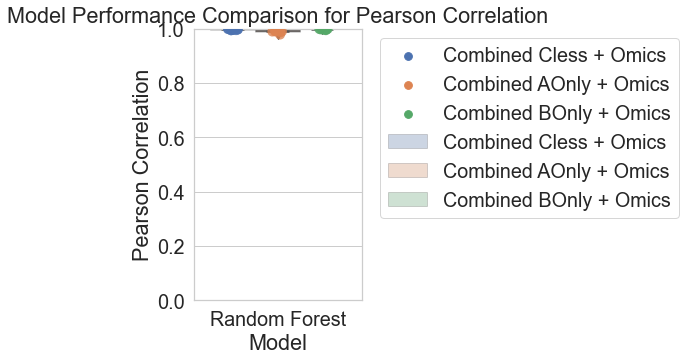

In [85]:
filtered_df = plot_specific_data_types(example_df, ['Combined Cless + Omics', 'Combined AOnly + Omics', 'Combined BOnly + Omics'], 'Random Forest')

In [88]:
pivot_result = get_mean_pearson_pivot(example_df, ['Combined Cless + Omics', 'Combined AOnly + Omics', 'Combined BOnly + Omics'], 'Random Forest')
print(pivot_result)

Model                   Random Forest
Feature Data                         
Combined AOnly + Omics       0.989721
Combined BOnly + Omics       0.996814
Combined Cless + Omics       0.996036


In [87]:
multiple_t_test_results = multiple_t_test(example_df, ['Combined Cless + Omics', 'Combined AOnly + Omics', 'Combined BOnly + Omics'], 'Random Forest')
multiple_t_test_results

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined AOnly + Omics,Combined BOnly + Omics,-4.672677,0.001164,0.003493
1,Combined AOnly + Omics,Combined Cless + Omics,-4.184796,0.002359,0.007078
2,Combined BOnly + Omics,Combined Cless + Omics,2.120196,0.063018,0.189053


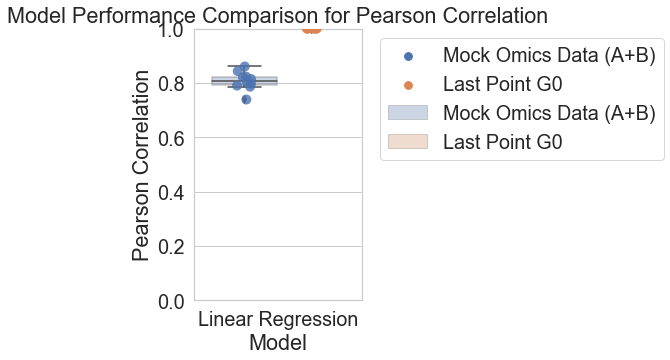

In [46]:
# compare between specific types of the 'Feature Data' column

# get the unique values of the 'Feature Data' column
unique_feature_data = example_df['Feature Data'].unique()
# get the unique values of the 'Model' column
unique_models = example_df['Model'].unique()

# compare against 'Mock Omics Data (A+B)' and 'Last Point G0' as a histogram for the Model 'Linear Regression' only 

# filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
# filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' or 'Last Point G0'
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point G0'])]
# plot box plot for the pearson correlation of the filtered dataframe
plt.figure(figsize=(3, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=filtered_df, x='Model', y='Pearson Correlation',
              hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
sns.boxplot(data=filtered_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.show()

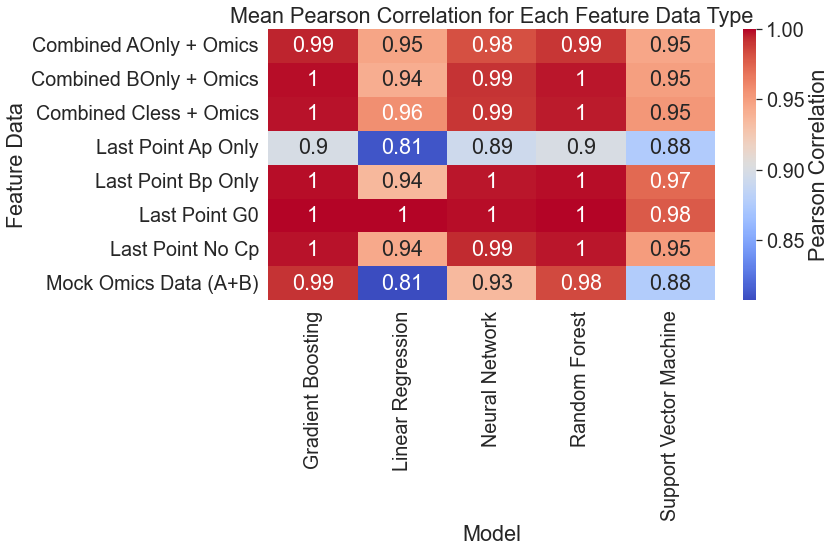

In [81]:
# calculate the mean pearson correlation for each feature data type
mean_pearson = example_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].mean().reset_index()
# pivot the dataframe to get the mean pearson correlation for each feature data type
mean_pearson_pivot = mean_pearson.pivot(index='Feature Data', columns='Model', values='Pearson Correlation')
# plot the mean pearson correlation for each feature data type
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.heatmap(mean_pearson_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Mean Pearson Correlation for Each Feature Data Type')
plt.xlabel('Model')
plt.ylabel('Feature Data')
plt.show()

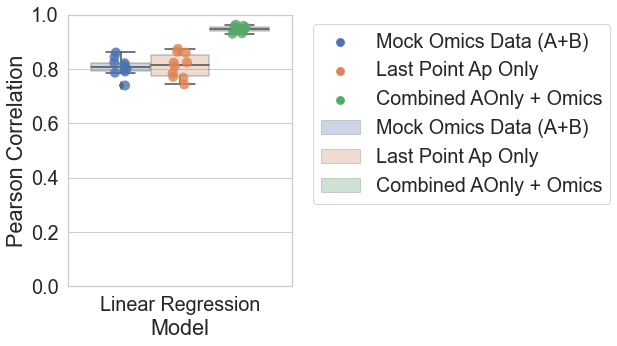

In [68]:
# filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
# filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' or 'Last Point G0'
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point Ap Only', 'Combined AOnly + Omics'])]
# plot box plot for the pearson correlation of the filtered dataframe
plt.figure(figsize=(4, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=filtered_df, x='Model', y='Pearson Correlation',
              hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
sns.boxplot(data=filtered_df, x='Model',
            y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.show()

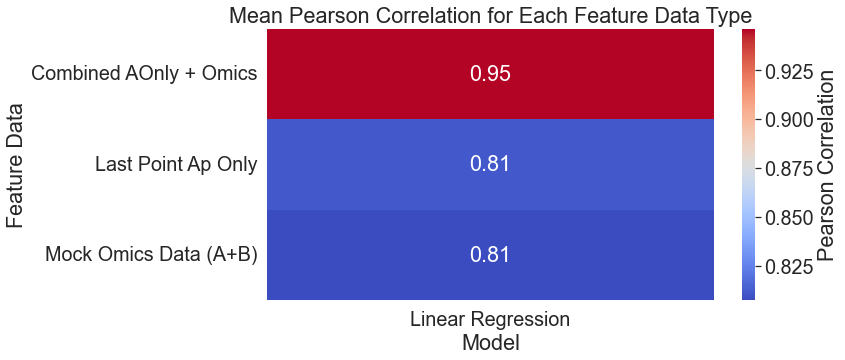

In [69]:
# calculate the mean pearson correlation for each feature data type
mean_pearson = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].mean().reset_index()
# pivot the dataframe to get the mean pearson correlation for each feature data type
mean_pearson_pivot = mean_pearson.pivot(index='Feature Data', columns='Model', values='Pearson Correlation')
# plot the mean pearson correlation for each feature data type
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.heatmap(mean_pearson_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Mean Pearson Correlation for Each Feature Data Type')
plt.xlabel('Model')
plt.ylabel('Feature Data')
plt.show()

In [70]:
# perform a multiple t-test for the pearson correlation of the filtered dataframe and adjust the p-values using the Bonferroni correction
from scipy.stats import ttest_rel

# apply on the filtered dataframe
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point Ap Only', 'Combined AOnly + Omics'])]
# get the pearson correlation for each feature data type
pearson_correlation = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].apply(list).reset_index()
# perform a t-test for each pair of feature data types
t_test_results = []
for i in range(len(pearson_correlation)):
    for j in range(i+1, len(pearson_correlation)):
        # perform a t-test for each pair of feature data types
        t_stat, p_value = ttest_rel(pearson_correlation['Pearson Correlation'][i], pearson_correlation['Pearson Correlation'][j])
        # append the results to the list
        t_test_results.append((pearson_correlation['Feature Data'][i], pearson_correlation['Feature Data'][j], t_stat, p_value))
# create a dataframe from the t-test results
t_test_df = pd.DataFrame(t_test_results, columns=['Data Type 1', 'Data Type 2', 't-statistic', 'p-value'])
# adjust the p-values using the Bonferroni correction
t_test_df['Bonferroni p-value'] = t_test_df['p-value'] * len(t_test_df)
# print the t-test results
t_test_df

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined AOnly + Omics,Last Point Ap Only,12.124941,7.049280e-07,0.000002
1,Combined AOnly + Omics,Mock Omics Data (A+B),11.587883,1.036387e-06,0.000003
2,Last Point Ap Only,Mock Omics Data (A+B),0.202427,8.440847e-01,2.532254


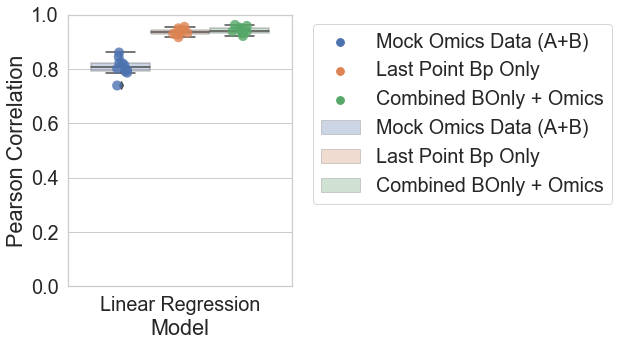

In [71]:
# filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
# filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' or 'Last Point G0'
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point Bp Only', 'Combined BOnly + Omics'])]
# plot box plot for the pearson correlation of the filtered dataframe
plt.figure(figsize=(4, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=filtered_df, x='Model', y='Pearson Correlation',
              hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
sns.boxplot(data=filtered_df, x='Model',
            y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.show()

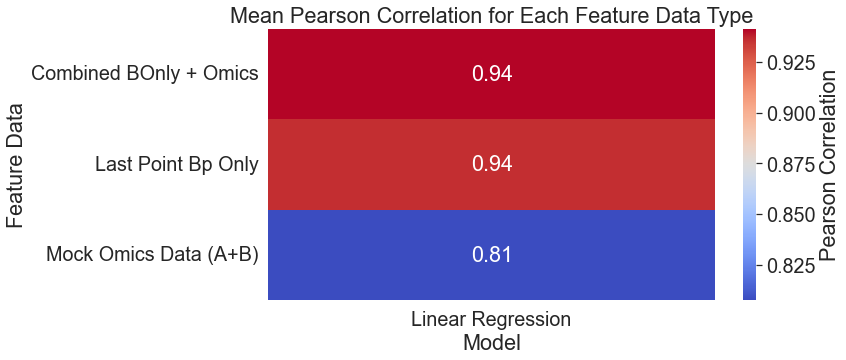

In [72]:
# calculate the mean pearson correlation for each feature data type
mean_pearson = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].mean().reset_index()
# pivot the dataframe to get the mean pearson correlation for each feature data type
mean_pearson_pivot = mean_pearson.pivot(index='Feature Data', columns='Model', values='Pearson Correlation')
# plot the mean pearson correlation for each feature data type
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.heatmap(mean_pearson_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Mean Pearson Correlation for Each Feature Data Type')
plt.xlabel('Model')
plt.ylabel('Feature Data')
plt.show()

In [ ]:
print(mean_pearson_pivot)

Model                   Linear Regression
Feature Data                             
Combined BOnly + Omics           0.941441
Last Point Bp Only               0.935843
Mock Omics Data (A+B)            0.807388


In [73]:
# perform a multiple t-test for the pearson correlation of the filtered dataframe and adjust the p-values using the Bonferroni correction
from scipy.stats import ttest_rel

# apply on the filtered dataframe
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point Bp Only', 'Combined BOnly + Omics'])]
# get the pearson correlation for each feature data type
pearson_correlation = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].apply(list).reset_index()
# perform a t-test for each pair of feature data types
t_test_results = []
for i in range(len(pearson_correlation)):
    for j in range(i+1, len(pearson_correlation)):
        # perform a t-test for each pair of feature data types
        t_stat, p_value = ttest_rel(pearson_correlation['Pearson Correlation'][i], pearson_correlation['Pearson Correlation'][j])
        # append the results to the list
        t_test_results.append((pearson_correlation['Feature Data'][i], pearson_correlation['Feature Data'][j], t_stat, p_value))
# create a dataframe from the t-test results
t_test_df = pd.DataFrame(t_test_results, columns=['Data Type 1', 'Data Type 2', 't-statistic', 'p-value'])
# adjust the p-values using the Bonferroni correction
t_test_df['Bonferroni p-value'] = t_test_df['p-value'] * len(t_test_df)
# print the t-test results
t_test_df

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined BOnly + Omics,Last Point Bp Only,6.700691,0.000088,0.000265
1,Combined BOnly + Omics,Mock Omics Data (A+B),10.200699,0.000003,0.000009
2,Last Point Bp Only,Mock Omics Data (A+B),10.049269,0.000003,0.000010


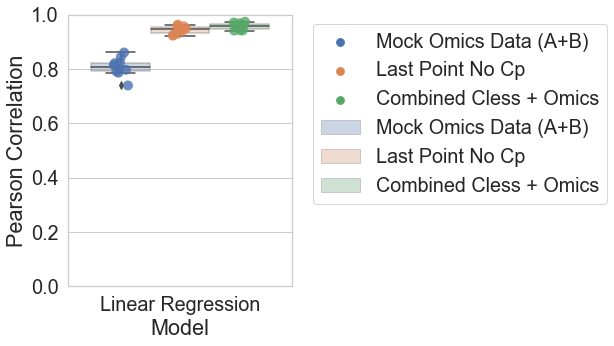

In [77]:
# filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
# filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' or 'Last Point G0'
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point No Cp', 'Combined Cless + Omics'])]
# plot box plot for the pearson correlation of the filtered dataframe
plt.figure(figsize=(4, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=filtered_df, x='Model', y='Pearson Correlation',
              hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
sns.boxplot(data=filtered_df, x='Model',
            y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.show()

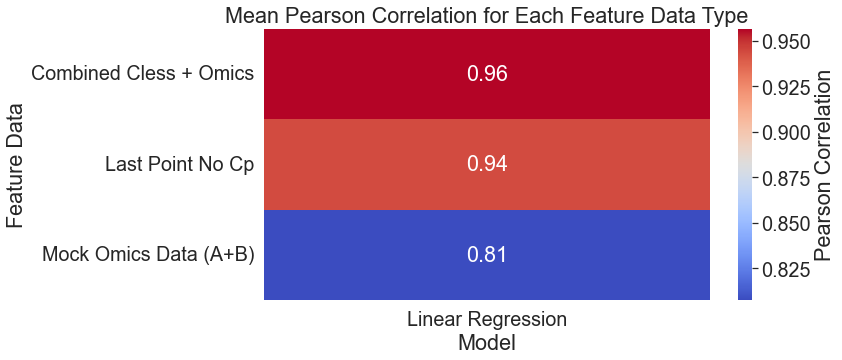

In [78]:
# calculate the mean pearson correlation for each feature data type
mean_pearson = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].mean().reset_index()
# pivot the dataframe to get the mean pearson correlation for each feature data type
mean_pearson_pivot = mean_pearson.pivot(index='Feature Data', columns='Model', values='Pearson Correlation')
# plot the mean pearson correlation for each feature data type
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.heatmap(mean_pearson_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Mean Pearson Correlation for Each Feature Data Type')
plt.xlabel('Model')
plt.ylabel('Feature Data')
plt.show()

In [79]:
print(mean_pearson_pivot)

Model                   Linear Regression
Feature Data                             
Combined Cless + Omics           0.956892
Last Point No Cp                 0.943610
Mock Omics Data (A+B)            0.807388


In [80]:
# perform a multiple t-test for the pearson correlation of the filtered dataframe and adjust the p-values using the Bonferroni correction
from scipy.stats import ttest_rel

# apply on the filtered dataframe
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point Bp Only', 'Combined BOnly + Omics'])]
# get the pearson correlation for each feature data type
pearson_correlation = filtered_df.groupby(['Feature Data', 'Model'])['Pearson Correlation'].apply(list).reset_index()
# perform a t-test for each pair of feature data types
t_test_results = []
for i in range(len(pearson_correlation)):
    for j in range(i+1, len(pearson_correlation)):
        # perform a t-test for each pair of feature data types
        t_stat, p_value = ttest_rel(pearson_correlation['Pearson Correlation'][i], pearson_correlation['Pearson Correlation'][j])
        # append the results to the list
        t_test_results.append((pearson_correlation['Feature Data'][i], pearson_correlation['Feature Data'][j], t_stat, p_value))
# create a dataframe from the t-test results
t_test_df = pd.DataFrame(t_test_results, columns=['Data Type 1', 'Data Type 2', 't-statistic', 'p-value'])
# adjust the p-values using the Bonferroni correction
t_test_df['Bonferroni p-value'] = t_test_df['p-value'] * len(t_test_df)
# print the t-test results
t_test_df

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined BOnly + Omics,Last Point Bp Only,6.700691,0.000088,0.000265
1,Combined BOnly + Omics,Mock Omics Data (A+B),10.200699,0.000003,0.000009
2,Last Point Bp Only,Mock Omics Data (A+B),10.049269,0.000003,0.000010


In [54]:
# perform a paired t-test for the pearson correlation of the filtered dataframe
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon

# filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
filtered_df = example_df[example_df['Model'] == 'Linear Regression']
# filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' or 'Last Point G0'
filtered_df = filtered_df[filtered_df['Feature Data'].isin(['Mock Omics Data (A+B)', 'Last Point G0'])]
# get the pearson correlation for the 'Mock Omics Data (A+B)' and 'Last Point G0'
mock_omics = filtered_df[filtered_df['Feature Data'] == 'Mock Omics Data (A+B)']['Pearson Correlation'].values
last_point = filtered_df[filtered_df['Feature Data'] == 'Last Point G0']['Pearson Correlation'].values
# perform a paired t-test
t_stat, p_value = ttest_rel(mock_omics, last_point)
print(f'Paired t-test: t-statistic = {t_stat}, p-value = {p_value}')

Paired t-test: t-statistic = -18.11997531062036, p-value = 2.1647040764094024e-08


In [ ]:
# get the unique values of the 'Feature Data' column
unique_feature_data = example_df['Feature Data'].unique()
# get the unique values of the 'Model' column
unique_models = example_df['Model'].unique()
print(unique_feature_data)

['Mock Omics Data (A+B)' 'Last Point G0' 'Last Point No Cp'
 'Last Point Ap Only' 'Last Point Bp Only' 'Combined Cless + Omics'
 'Combined AOnly + Omics' 'Combined BOnly + Omics']
